In [2]:
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from karateclub import Graph2Vec
import os

from models.generator import *
from models.inverter import *
from models.discriminator import *
from models.dataset import *
from models.args import *

c:\ProgramData\Miniconda3\envs\gcn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GraphRNN Visualization

In [2]:
# outline
# assumption: GraphRNN samples and data are available.
# 1. use TSNE to visualize latent space
# 2. train graph2vec on true vs generated samples
# 3. use graph2vec to embed GraphRNN samples and true data in some (high-dimensional) Euclidean space
# 4. use TSNE to visualize those embeddings

# optional:
# color points in (4) and (1) depending on the number of nodes, (continuous) shade based on average degree, etc 

In [3]:
def load_data_n_models(args):
    # populate arguments
    train, labels = get_dataset_with_label(args.graph_type) # entire dataset as train
    # args.batch_size = num_data
    train_dataset = Graph_sequence_sampler_pytorch(train, labels, args)
    train_loader, adj_shape = get_dataloader_labels(train_dataset, args)
    noise_dim = args.hidden_size_rnn
    netG = GraphRNN(args=args)
    netI = Inverter(input_dim=512, output_dim=args.hidden_size_rnn, hidden_dim=256)
    netD = TestNN(adj_shape[0]*adj_shape[1], 1)

    # load weights
    netG.load_state_dict(torch.load("./cache/graphrnn/saved_model/generator.pth", map_location=torch.device('cpu')))
    netI.load_state_dict(torch.load("./cache/graphrnn/saved_model/inverter.pth", map_location=torch.device('cpu')))
    netD.load_state_dict(torch.load("./cache/graphrnn/saved_model/discriminator.pth", map_location=torch.device('cpu')))
    netI.eval()
    netG.eval()
    netD.eval()
    return netG, netI, netD, train_loader

calculating max previous node, total iteration: 12000
iter 0 times
iter 2400 times
iter 4800 times
iter 7200 times
iter 9600 times
max previous node: 10
[[[0. 1. 1. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 1. 1. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 1. 1. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 1. 1. 0.]]

 ...

 [[0. 1. 1. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 1. 1. 0.]]

 [[0. 1. 1. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[0. 1. 0. ... 0. 0.

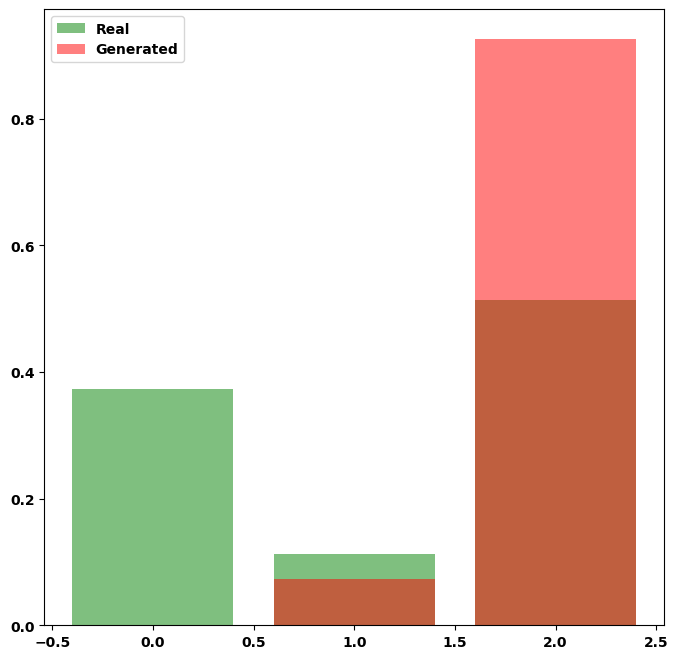

In [8]:
# generate degree distribution of the graphs 
def get_degree_distribution_plots(args, num_of_datapoints=512):
    """Generate the TSNE plots with labels"""
    netG, netI, _, train_loader = load_data_n_models(args)

    # get padded data
    iterator = iter(train_loader)
    temp = next(iterator)
    real_data = temp['adj_mat'].numpy()
    real_label = temp['label'].numpy().T[0, :]
    if num_of_datapoints > real_data.shape[0]:
        while real_data.shape[0] < num_of_datapoints: 
            temp = next(iterator)
            one_batch = temp['adj_mat'].numpy()
            one_label = temp['label'].numpy().T[0, :]
            real_data = np.concatenate([real_data, one_batch], axis=0)
            real_label = np.concatenate([real_label, one_label], axis=0)
        real_data = real_data[:num_of_datapoints, :]
        real_label = real_label[:num_of_datapoints]
    real_data = [nx.from_numpy_matrix(real) for real in real_data]
    
    # create aggregated degree distribution 
    dmax = max([max((d for n, d in G.degree())) for G in real_data])
    hist_bin = list(range(dmax))
    degree_distribution = np.zeros_like(hist_bin[:-1])
    for G in real_data:
        degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
        temp_hist = np.histogram(degree_sequence, bins=hist_bin)[0]
        degree_distribution += temp_hist

    # generate samples
    gen_latent = torch.randn(args.batch_size, args.hidden_size_rnn) # latent space representation
    iterator = iter(train_loader)
    temp = next(iterator)
    X, Y, length = temp['x'], temp['y'], temp['len']
    gen_data = np.where(netG(gen_latent, X, Y, length).detach().numpy() > 0, 1.0, 0.0) 
    # print(gen_data.shape)
    count = len(gen_data) 
    if num_of_datapoints > args.batch_size:
        while count <= num_of_datapoints: 
            temp = next(iterator)
            X, Y, length = temp['x'], temp['y'], temp['len']
            one_batch = np.where(netG(gen_latent, X, Y, length).detach().numpy() > 0, 1.0, 0.0) 
            # one_batch = netG(gen_latent, X, Y, length, 'cuda')
            # print(one_batch)
            gen_data = np.concatenate([gen_data, one_batch], axis=0)
            count += args.batch_size
        # print(len(gen_data))
        # print(gen_data.shape)
        gen_data = gen_data[:num_of_datapoints, :, :]
    # print(gen_data.shape)
    gen_data = [nx.from_numpy_matrix(gen) for gen in gen_data]
    # gen degree distribution
    gen_degree_distribution = np.zeros_like(hist_bin[:-1])
    for G in gen_data:
        degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
        temp_hist = np.histogram(degree_sequence, bins=hist_bin)[0]
        gen_degree_distribution += temp_hist

    # plot the two distribution against each other 
    fig, axs = plt.subplots(figsize=(8,8))
    axs.bar(range(len(degree_distribution)), degree_distribution/sum(degree_distribution), label="Real", color='green', alpha=0.5)
    axs.bar(range(len(gen_degree_distribution)), gen_degree_distribution/sum(gen_degree_distribution), label="Generated", color='red', alpha=0.5)
    axs.legend()
    plt.show()
    

args=Args()
get_degree_distribution_plots(args, 100)

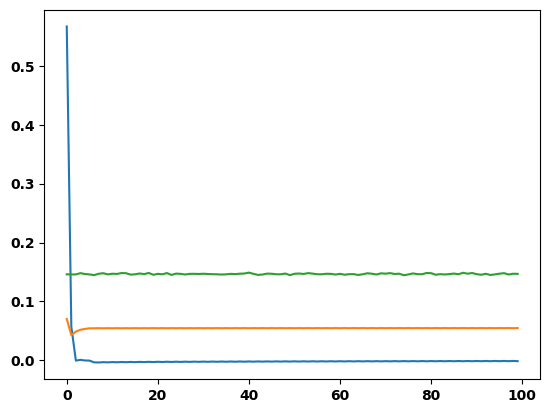

In [5]:
def plot_losses(): 
    dloss_fp = './cache/graphrnn/loss_results/discriminator_loss.txt'
    gloss_fp = './cache/graphrnn/loss_results/generator_loss.txt'
    iloss_fp = './cache/graphrnn/loss_results/inverter_loss.txt'

    dloss = np.loadtxt(dloss_fp)
    gloss = np.loadtxt(gloss_fp)
    iloss = np.loadtxt(iloss_fp)

    plt.plot(dloss, label='discriminator')
    plt.plot(gloss, label='generator')
    plt.plot(iloss, label='inverter')

plot_losses()
